# Predicción de sueldos

El objetivo de este notebook es hacer un modelo sencillo que pueda estimar el sueldo de una persona respondiendo una encuesta como la de sysarmy, usando los datos de principios de 2020.

## Baseline

Vamos a tomar un modelo de base para ver cuánto podemos mejorarlo. En análisis previos vimos que las tres características que más definen el sueldo son el género, la ubicación y cuánta gente a cargo tiene la persona. Vamos a hacer un modelo que dada estas tres características memorice el promedio de los valores vistos y estime eso. En caso de ser una combinación no vista puede devolver el promedio general.

In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import xgboost as xgb
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import Sequential
from keras.regularizers import l1, l2

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [4]:
df.T.index

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',


In [5]:
df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']]

,Me identifico,Dónde estás trabajando,¿Gente a cargo?
0,Hombre,Catamarca,0
1,Mujer,Catamarca,5
2,Hombre,Chaco,6
3,Hombre,Chaco,0
4,Hombre,Chaco,1
...,...,...,...
5977,Hombre,Tucumán,0
5978,Hombre,Tucumán,1
5979,Hombre,Tucumán,0
5980,Mujer,Tucumán,6


In [6]:
df.groupby('Me identifico').size()

Me identifico
Hombre    5081
Mujer      872
Otros       29
dtype: int64

In [7]:
df.groupby('Dónde estás trabajando').size()

Dónde estás trabajando
Catamarca                             2
Chaco                                33
Chubut                               22
Ciudad Autónoma de Buenos Aires    4105
Corrientes                           16
Córdoba                             316
Entre Ríos                           41
Formosa                               3
GBA                                 432
Jujuy                                15
La Pampa                              2
La Rioja                              8
Mendoza                             112
Misiones                             22
Neuquén                              26
Provincia de Buenos Aires           457
Río Negro                            23
Salta                                10
San Juan                              6
San Luis                              6
Santa Cruz                            2
Santa Fe                            287
Santiago del Estero                   4
Tierra del Fuego                      5
Tucumán          

In [8]:
df.groupby('¿Gente a cargo?').size()

¿Gente a cargo?
0                            4479
1                             278
10                             72
100                             2
105                             1
11                              9
110                             1
12                             21
120                             1
13                              7
130                             1
14                             15
15                             32
150                             1
1555555555555555555555555       1
16                              4
160                             1
17                              2
18                              6
19                              3
2                             274
20                             33
200                             2
21                              1
22                              4
23                              2
230                             1
24                              2
25                              

El género y provincia son variables categóricas, es decir que pueden obtener un conjunto de valores, mientras que gente a cargo es un número. Vemos también que algunas categorías tienen pocos datos, como género no binario o la provincia de Catamarca. En general esto va a ser un problema porque no va a generalizar muy bien ningún modelo con tan poca información.

Veamos si podemos agrupar estos.

In [9]:
df[['Me identifico', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Me identifico').median()

,Salario mensual BRUTO (en tu moneda local)
Me identifico,
Hombre,75000.0
Mujer,60000.0
Otros,55000.0


In [3]:
df_provinces = df[['Dónde estás trabajando', 'Salario mensual BRUTO (en tu moneda local)']].groupby('Dónde estás trabajando').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))
df_provinces

Salario mensual BRUTO (en tu moneda local)  \
                                                                    median   
Dónde estás trabajando                                                       
Santiago del Estero                                              41500.000   
Corrientes                                                       42100.000   
La Rioja                                                         43500.000   
Jujuy                                                            45000.000   
Misiones                                                         46000.000   
Catamarca                                                        50500.000   
Mendoza                                                          55000.000   
Santa Cruz                                                       57500.000   
Entre Ríos                                                       59000.000   
Neuquén                                                          62500.000   
Provincia de Buenos Aires                                        65000.000   
Chaco                                                            65784.000   
Tucumán                                                          66000.000   
GBA                                                              66154.500   
Salta                                                            66950.500   
Córdoba                                                          72500.000   
San Juan                                                         72667.375   
Santa Fe                                                         73000.000   
Ciudad Autónoma de Buenos Aires                                  75000.000   
Río Negro                                                        78000.000   
Formosa                                                          80000.000   
Chubut                                                           83000.000   
San Luis                                                         97000.000   
La Pampa                                                        105250.000   
Tierra del Fuego                                                120000.000   

                                       
                                count  
Dónde estás trabajando                 
Santiago del Estero                 4  
Corrientes                         16  
La Rioja                            8  
Jujuy                              15  
Misiones                           22  
Catamarca                           2  
Mendoza                           112  
Santa Cruz                          2  
Entre Ríos                         41  
Neuquén                            26  
Provincia de Buenos Aires         457  
Chaco                              33  
Tucumán                            27  
GBA                               432  
Salta                              10  
Córdoba                           316  
San Juan                            6  
Santa Fe                          287  
Ciudad Autónoma de Buenos Aires  4105  
Río Negro                          23  
Formosa                             3  
Chubut                             22  
San Luis                            6  
La Pampa                            2  
Tierra del Fuego                    5

In [4]:
provinces_geo = gpd.read_file('provincias_argentinas_polygon.geojson')
provinces_geo.head()

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037..."
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961..."
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407..."
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446..."
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182..."


In [12]:
provinces_geo.provincia

0                Ciudad Autónoma de Buenos Aires
1                                      Catamarca
2                                          Chaco
3                                         Chubut
4                                     Corrientes
5                                     Entre Ríos
6                                        Formosa
7                                          Jujuy
8                                       La Pampa
9                                       La Rioja
10                                       Mendoza
11                                      Misiones
12                                       Neuquén
13                                     Río Negro
14                                         Salta
15                                      San Juan
16                                      San Luis
17                                    Santa Cruz
18                                      Santa Fe
19                           Santiago del Estero
20                  

In [5]:
provinces_geo['provincia'] = provinces_geo['provincia'].apply(lambda x: "Tierra del Fuego" if x == "Tierra del Fuego e Islas del Atlántico Sur" else x)

In [6]:
provinces = provinces_geo.join(df_provinces['Salario mensual BRUTO (en tu moneda local)'], on=['provincia'])
provinces

,cartodb_id,description,name,provincia,id,codpcia,c_indec,id_dyp,geometry,median,count
0,1,,,Ciudad Autónoma de Buenos Aires,1,1,2,1,"MULTIPOLYGON (((-58.39007 -34.66230, -58.39037...",75000.000,4105
1,3,,,Catamarca,3,3,10,4,"MULTIPOLYGON (((-66.59111 -26.17318, -66.58961...",50500.000,2
2,4,,,Chaco,4,4,22,6,"MULTIPOLYGON (((-62.34757 -24.11021, -62.34407...",65784.000,33
3,5,,,Chubut,5,5,26,7,"MULTIPOLYGON (((-71.77158 -41.99955, -71.67446...",83000.000,22
4,7,,,Corrientes,7,7,18,5,"MULTIPOLYGON (((-58.89298 -27.99935, -58.89182...",42100.000,16
5,8,,,Entre Ríos,8,8,30,8,"MULTIPOLYGON (((-59.66084 -30.34857, -59.65614...",59000.000,41
6,9,,,Formosa,9,9,34,9,"MULTIPOLYGON (((-62.34465 -22.45495, -62.33563...",80000.000,3
7,10,,,Jujuy,10,10,38,10,"MULTIPOLYGON (((-64.44379 -23.63491, -64.44048...",45000.000,15
8,11,,,La Pampa,11,11,42,11,"MULTIPOLYGON (((-65.10672 -34.99768, -65.02612...",105250.000,2
9,12,,,La Rioja,12,12,46,12,"MULTIPOLYGON (((-69.09436 -27.77274, -69.01274...",43500.000,8


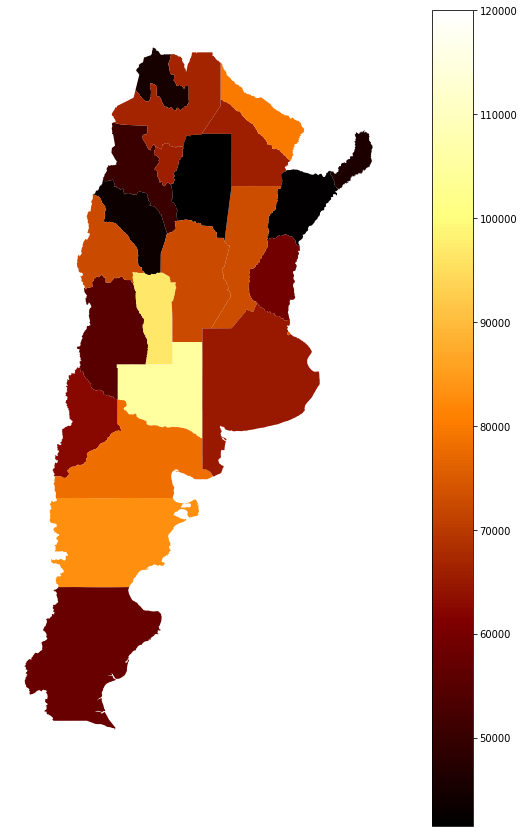

In [15]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='median', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

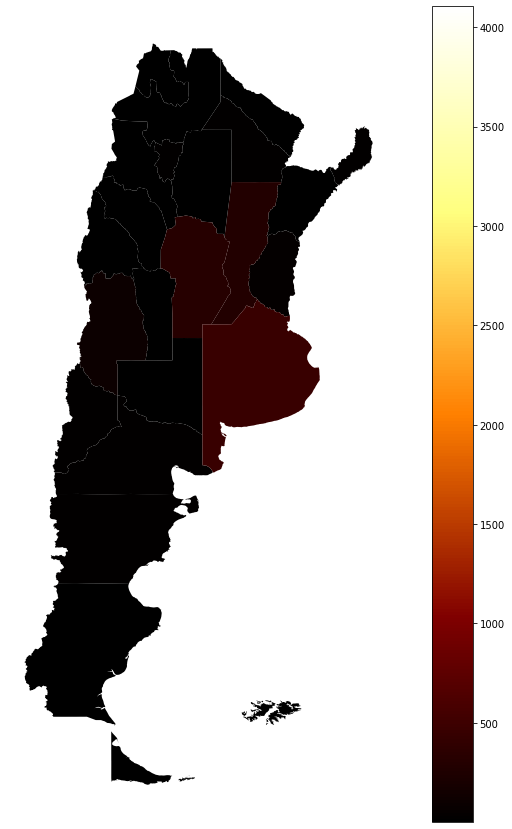

In [16]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='count', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

Como la escala está dominada por CABA, apenas podemos ver que PBA, Santa Fe y Córdoba tienen datos y el resto del país casi nada. Usemos logaritmo en base 10 para ver la orden de magnitud de cada provincia.

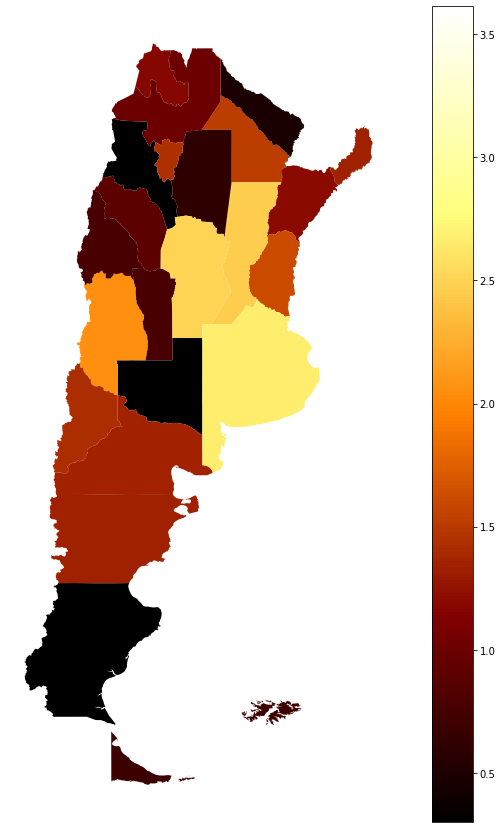

In [17]:
provinces['log(count)'] = provinces['count'].apply(lambda x: math.log10(x))
f, ax = plt.subplots(1, figsize=(15, 15))
ax = provinces.plot(column='log(count)', cmap='afmhot', ax=ax, legend=True)
ax.axis('off')
plt.show()

Vemos algún patrón en estos gráficos. El área de la Pampa Húmeda (Provincia de Buenos Aires, Santa Fe, Córdoba, La Pampa) parece tener más datos, y valores más altos. El Noroeste (Jujuy, Salta, Tucumán, La Rioja, Catamarca) tienen menos observaciones y promedios más bajos. En la Patagonia (Neuquén, Río Negro, Chubut, Santa Cruz) Santa Cruz parece tener un sueldo más bajo que el resto, pero vemos que son pocas observaciones. Pasa lo opuesto en el norte, donde Formosa es más alto pero sólo con 3 personas. Cuyo (Mendoza, San Luis, San Juan) parece ser menos homogéneo, sabiendo que San Luis tiene políticas de incentivo a la actividad económica tiene sentido.

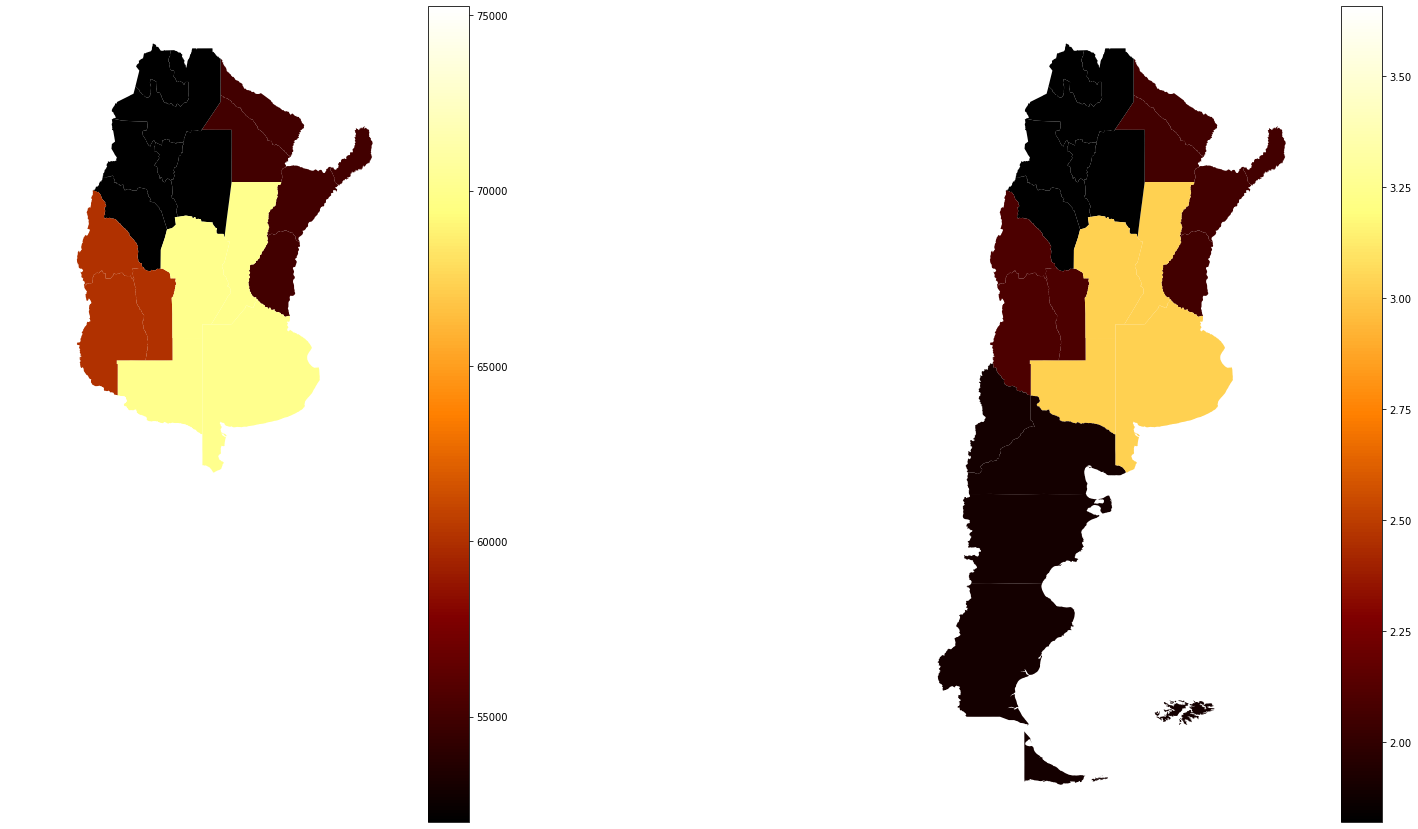

In [7]:
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
provinces_geo['region'] = provinces_geo['provincia'].apply(lambda x: regions_map[x])
df['region'] = df['Dónde estás trabajando'].apply(lambda x: regions_map[x])
df_regions = df[['region', 'Salario mensual BRUTO (en tu moneda local)']].groupby('region').agg(['median', 'count']).sort_values(('Salario mensual BRUTO (en tu moneda local)', 'median'))

regions = provinces_geo.join(df_regions['Salario mensual BRUTO (en tu moneda local)'], on=['region'])
regions['log(count)'] = regions['count'].apply(lambda x: math.log10(x))


f, (ax0, ax1) = plt.subplots(ncols=2, figsize=(30, 15))
ax0 = regions.plot(column='median', cmap='afmhot', ax=ax0, legend=True)
ax0.axis('off')

ax1 = regions.plot(column='log(count)', cmap='afmhot', ax=ax1, legend=True)
ax1.axis('off')

plt.show()

Ahora tenemos una mediana para cada región, y tenemos muestra de dos dígitos o más en cada una.

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


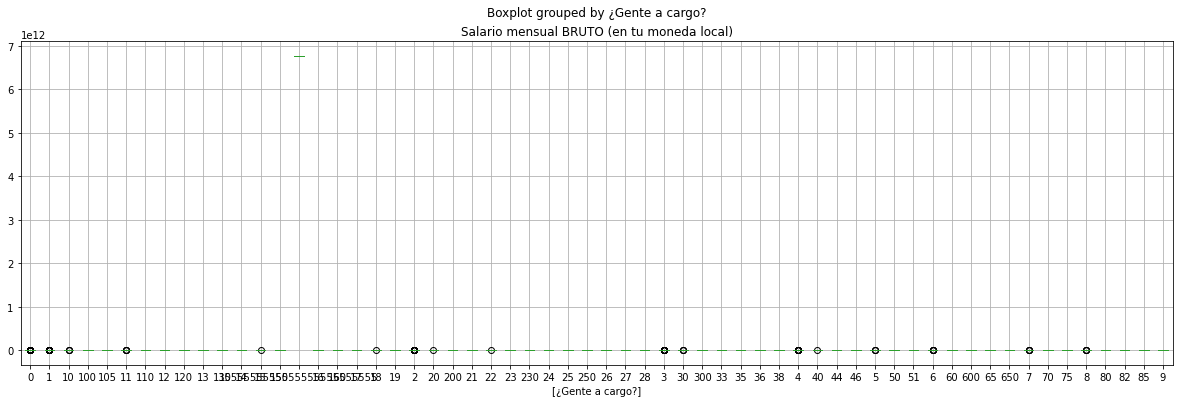

In [19]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].boxplot(by='¿Gente a cargo?', figsize=(20, 6));

In [20]:
df['Salario mensual BRUTO (en tu moneda local)'].max()

6777729990111.0

In [8]:
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]

/home/seppo/.local/share/virtualenvs/sysarmy-sueldos-2020.1-QyVfVxlk/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


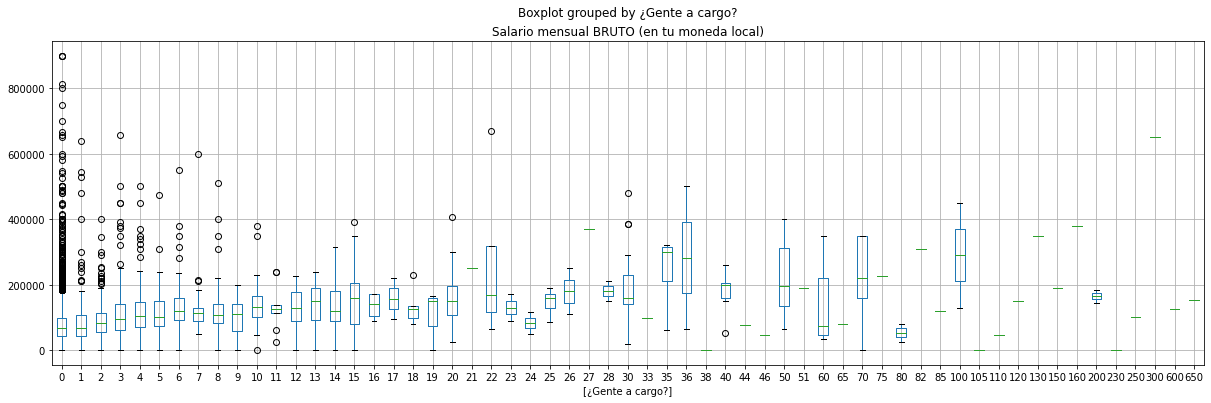

In [22]:
df[['¿Gente a cargo?', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='¿Gente a cargo?').boxplot(by='¿Gente a cargo?', figsize=(20, 6));

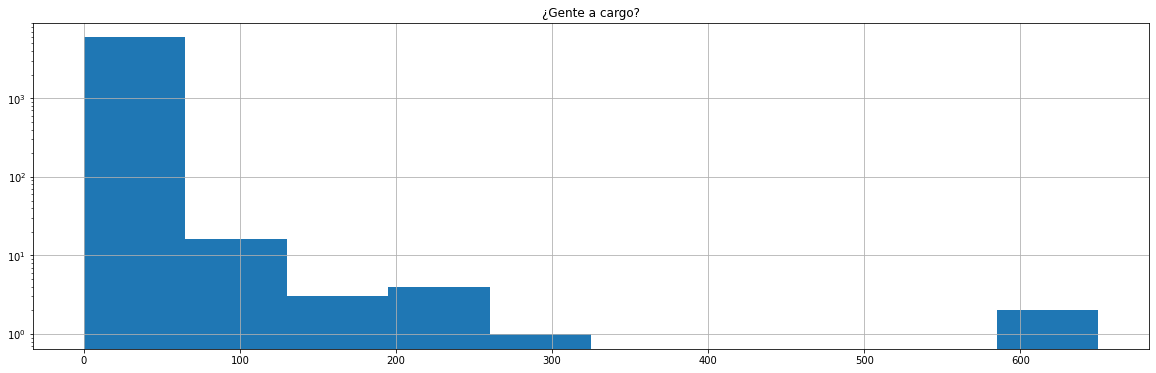

In [23]:
df[['¿Gente a cargo?']].astype(int).sort_values(by='¿Gente a cargo?').hist(figsize=(20, 6), log=True);

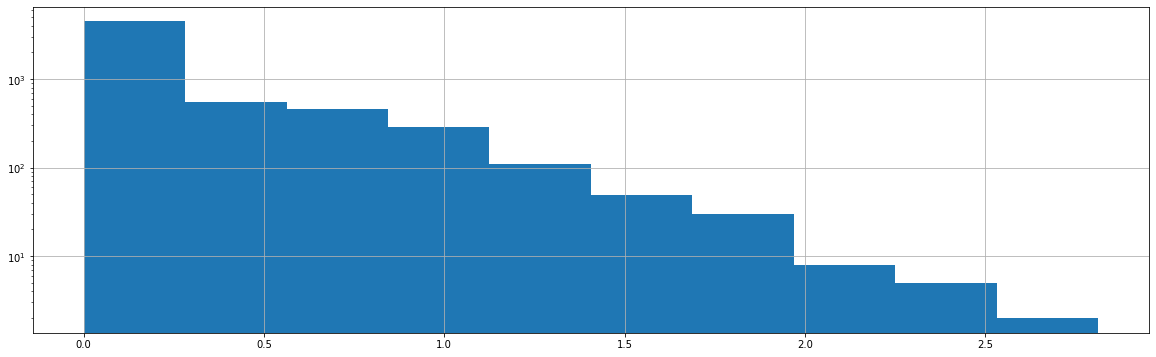

In [24]:
df['¿Gente a cargo?'].astype(int).sort_values().apply(lambda x: math.log10(x+1)).hist(figsize=(20, 6), log=True);

In [9]:
g = df['¿Gente a cargo?'].astype(int)
pd.qcut(g, 10, duplicates='drop', retbins=True)[1]

array([  0.,   2.,   5., 650.])

/home/sebastianwaisbrot/.local/share/virtualenvs/sysarmy-sueldos-2020.1-TStUcAYq/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


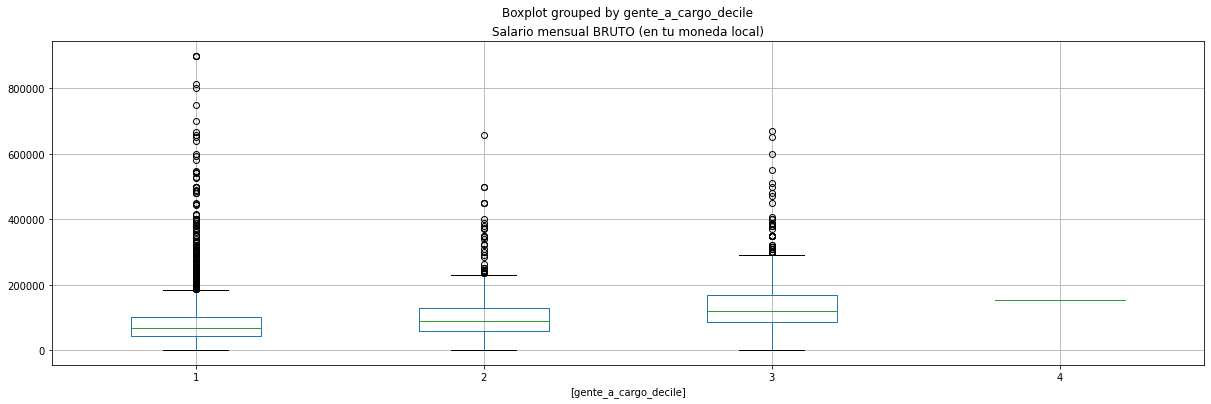

In [10]:
deciles = pd.qcut(g, 10, duplicates='drop', retbins=True)[1]
df['gente_a_cargo_decile'] = df['¿Gente a cargo?'].astype(int).apply(lambda x: (deciles <= x).sum())
df[['gente_a_cargo_decile', 'Salario mensual BRUTO (en tu moneda local)']].astype(int).sort_values(by='gente_a_cargo_decile').boxplot(by='gente_a_cargo_decile', figsize=(20, 6));

Ahora ya estamos listos para armar una predicción básica. Calculamos el promedio para la gente de la misma región geográfica, mismo género (considerando "otro" como "mujer" por ser más parecido su sueldo) y mismo decil con gente a cargo.

In [11]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}

In [26]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class BaseModel:
    def __init__(self, num_gente_a_cargo_groups=10):
        self.num_gente_a_cargo_groups = num_gente_a_cargo_groups

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: regions_map[x])
        df['gender'] = X['Me identifico'].apply(lambda x: gender_map[x])
        df['gente_a_cargo_group'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: (self.groups_ <= x).sum())
        df['key'] = df.apply(lambda row: '{},{},{}'.format(row['region'], row['gender'], row['gente_a_cargo_group']), axis=1)
        return df

    def get_params(self, deep=True):
        return {'num_gente_a_cargo_groups': self.num_gente_a_cargo_groups}

    def set_params(self, **params):
        if 'num_gente_a_cargo_groups' in params:
            self.num_gente_a_cargo_groups = params['num_gente_a_cargo_groups']
    
    def fit(self, X, y):
        self.groups_ = pd.qcut(X['¿Gente a cargo?'].astype(int), self.num_gente_a_cargo_groups, duplicates='drop', retbins=True)[1]
        
        df = self._get_df(X)
        df['value'] = y
        self.mean_ = y.mean()
        self.means_ = df[['key', 'value']].groupby('key').mean().to_dict()['value']
        return self
    
    def predict(self, X):
        df = self._get_df(X)
        return df['key'].apply(lambda key: self.means_.get(key, self.mean_)).rename('y_pred')
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
m = BaseModel()
m.fit(X, y).score(X, y)

0.0756538701171876

In [27]:
cross_val_score(BaseModel(), X, y)

array([ 0.05912578,  0.06624877,  0.01944449,  0.02328854, -0.01219801])

In [28]:
best_p = 10
best_s = cross_val_score(BaseModel(best_p), X, y).mean()
for i in range(1, 100):
    s = cross_val_score(BaseModel(i), X, y).mean()
    if s > best_s:
        best_s = s
        best_p = i
(best_s, best_p)

(0.04011411251863235, 37)

Este modelo es bastante peor de lo que esperaba. Veamos un modelo de regresión lineal con estos mismos datos.

In [28]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(regions_map[x], self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].apply(lambda x: regions_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.045472258331214224

In [29]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.04569610636696928

In [30]:
gender_map = {
    'Hombre': 2,
    'Mujer': 1,
    'Otros': 0,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearModel(), X, y).mean()

0.045596020642121184

Probando no agrupar otros con mujeres el modelo empeora, dejando las provincias sin agrupar el modelo mejora. Usar logaritmo en vez de deciles para gente a cargo mejora (¡y es más sencillo de implementar!). Quedemosnos el mejor modelo que tenemos hasta ahora y agreguemos experiencia y nivel de estudio.

In [31]:
gender_map = {
    'Hombre': True,
    'Mujer': False,
    'Otros': False,
}
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
                                     
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.14055117647443893

In [12]:
df['Estado'].value_counts()

Completado    2932
En curso      1748
Incompleto    1292
Name: Estado, dtype: int64

In [13]:
df['Nivel de estudios alcanzado'].value_counts()

Universitario    3935
Terciario        1132
Secundario        553
Posgrado          321
Doctorado          21
Posdoctorado        8
Primario            2
Name: Nivel de estudios alcanzado, dtype: int64

In [30]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.study_ = pd.concat((X[['Nivel de estudios alcanzado', 'Estado']].apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']

        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15781202277215325

In [31]:
df['Carrera'].value_counts()

Ingeniería en Sistemas de Información        1078
Ingeniería en Informática                     741
Analista de Sistemas                          563
Licenciatura en Sistemas de Información       320
Licenciatura en Ciencias dela Computación     271
                                             ... 
Master en Ingenieria Industrial                 1
Analista en Diseño Digital                      1
Arquitecto en ciberseguridad                    1
autodidacta                                     1
Historia                                        1
Name: Carrera, Length: 572, dtype: int64

In [32]:
df['Universidad'].value_counts()

UTN - Universidad Tecnológica Nacional         1271
UBA - Universidad de Buenos Aires               830
UADE - Universidad Argentina De la Empresa      228
UNLaM - Universidad Nacional de La Matanza      196
UAI - Universidad Abierta Interamericana        162
                                               ... 
Universidad Americana                             1
UNER - Universidad Nacional de Entre Ríos         1
universidad de la marina mercante                 1
URBE - Universidad Dr Rafael Belloso Chacín       1
Universidad Rafael Urdaneta- Venezuela.           1
Name: Universidad, Length: 848, dtype: int64

In [37]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.09204226421744824

In [38]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15638080087703565

In [39]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15988516023297533

In [40]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.universities_ = X['Universidad'].value_counts()[X['Universidad'].value_counts() > X.shape[0] * 5 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
                X['Universidad'].apply(lambda x: x if x in self.universities_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.1526299924940517

In [41]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.15988516023297533

## doc2vec

Ya tenemos un modelo base que explica un 16% del sueldo. No es un gran número pero es una base sobre la que trabajar. Muchas de las variables que tenemos son categóricas así que probemos hacer un documento con cada registro y aplicar doc2vec para generar embeddings.
Empecemos sólo con los lenguajes de programación para ver cómo funciona.

In [42]:
documents = [TaggedDocument([x for x in df.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(df.shape[0])]
model = Doc2Vec(documents, vector_size=2, epochs=30)

In [43]:
embeddings = [model.docvecs[i] for i in range(len(model.docvecs))]

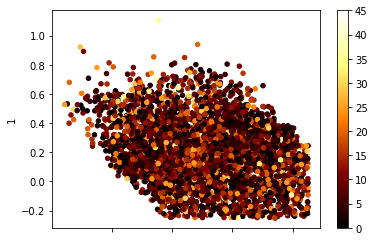

In [44]:
pd.DataFrame(embeddings).plot.scatter(0, 1, c=df['Años de experiencia'], cmap='afmhot');

In [45]:
class EmbeddingModel:
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x], [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=4, alpha=0.025, min_count=2, epochs=300)
        self.model_ = LinearRegression()
        self.model_.fit(pd.DataFrame([self.doc2vec_.docvecs[i] for i in range(len(self.doc2vec_.docvecs))]), y)
        return self
    
    def predict(self, X):
        return self.model_.predict([self.doc2vec_.infer_vector([x for x in X.iloc[i].fillna('')['Lenguajes de programación'].split(', ') if x]) for i in range(X.shape[0])])
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Lenguajes de programación']], df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(EmbeddingModel(), X, y).mean()

0.008280584439386507

In [83]:
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearEmbeddingModel(), X, y).mean()

0.16000891499736603

In [84]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=10), X, y).mean()

0.15981906013320776

In [85]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=100), X, y).mean()

0.16008415113073585

In [86]:
cross_val_score(LinearEmbeddingModel(vector_size=100, epochs=10), X, y).mean()

0.15986304581172256

In [87]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=20), X, y).mean()

0.1598453943802156

In [88]:
cross_val_score(LinearEmbeddingModel(vector_size=20, epochs=300), X, y).mean()

0.1598802000004143

In [89]:
cross_val_score(LinearEmbeddingModel(vector_size=10, epochs=300), X, y).mean()

0.15997267282251187

In [117]:
class XGBoostModel:
    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(XGBoostModel(), X, y).mean()

0.14695669129414224

In [116]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_words(self, row):
        return [
            f'{key}={row[key]}'
            for key
            in (
                'Tengo',
                'Realizaste cursos de especialización',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                '¿Tenés guardias?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in row.fillna('')[k].split(', ')
        ]

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(self._row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        documents = [TaggedDocument(self._row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        self.doc2vec_ = Doc2Vec(documents, vector_size=self.vector_size, alpha=0.025, min_count=2, epochs=self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(XGBoostEmbeddingModel(vector_size=20, epochs=400), X, y).mean()

0.08536419753314979

Yaks. Los embeddings parecen ser malos predictores por sí solo, no mejorar considerablemente un modelo de regresión lineal, y empeorar el un XGBoost.

In [149]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
m = LinearModel()
m.fit(X, y).score(X, y)
cross_val_score(LinearModel(), X, y).mean()

0.03898470959325508

In [14]:
df = df[df['Años en la empresa actual'] < 40]

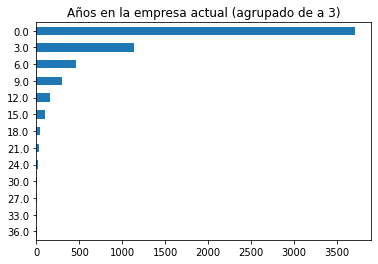

In [34]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh(title='Años en la empresa actual (agrupado de a 3)');

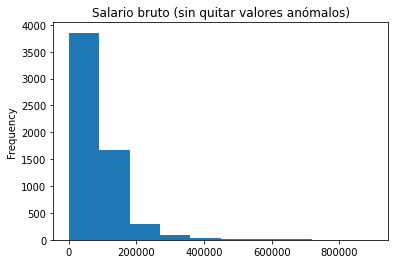

In [35]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto (sin quitar valores anómalos)');

In [36]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

5200    1.0
4561    1.0
3620    1.0
5721    1.0
2123    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [37]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

4636    800000.0
3868    814000.0
3839    900000.0
1974    900000.0
597     900007.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

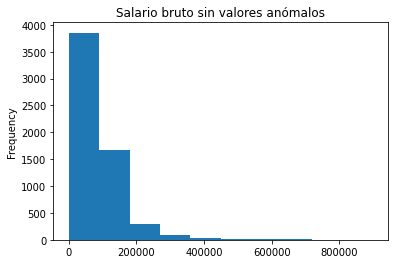

In [38]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

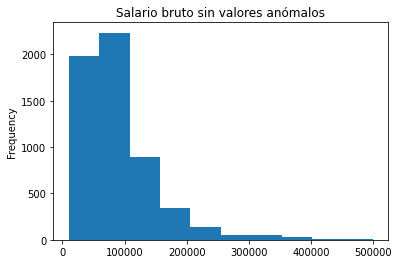

In [39]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 500000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist(title='Salario bruto sin valores anómalos');

In [15]:
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]

In [163]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log(x+1))
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Años de experiencia']], np.log(df['Salario mensual BRUTO (en tu moneda local)'])
m = LinearModel()
m.fit(X, y).score(X, y)
cross_val_score(LinearModel(), X, y).mean()

0.23873438624983842

In [183]:
doc2vec_cache = {}

def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace("", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ]

def get_doc2vec(df, vector_size, epochs):
    global doc2vec_cache
    h = pd.util.hash_pandas_object(df).sum(), vector_size, epochs
    if h not in doc2vec_cache:
        documents = [TaggedDocument(row_to_words(X.iloc[i]), [i]) for i in range(X.shape[0])]
        doc2vec_cache[h] = Doc2Vec(documents, vector_size=vector_size, alpha=0.025, min_count=2, epochs=epochs)
    return doc2vec_cache[h]
    
    
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

In [184]:
X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
cross_val_score(LinearEmbeddingModel(), X, y).mean()

0.24247811334801472

In [166]:
for vector_size in range(3, 15, 4):
    for epochs in range(3, 15, 4):
        X, y = df, df['Salario mensual BRUTO (en tu moneda local)']
        print(
            vector_size,
            epochs,
            cross_val_score(LinearEmbeddingModel(vector_size=vector_size, epochs=epochs), X, y).mean(),
        )

3 3 0.24228056196514053
3 7 0.24238767714352621
3 11 0.2424223169291107
7 3 0.24236828770498672
7 7 0.2423563399831988
7 11 0.24244660584287764
11 3 0.24253530370471874
11 7 0.24224796546350708
11 11 0.24224614551226945


In [185]:
space = {
    'vector_size': hp.choice('vector_sice', range(3, 100)),
    'epochs': hp.choice('epochs', range(10, 400)),
}

def objective(params):
    score = cross_val_score(LinearEmbeddingModel(**params), X, y).mean()
    print(params, score)
    return -score

fmin(objective, space, algo=tpe.suggest, max_evals=100)

{'epochs': 135, 'vector_size': 63}                     
0.2424581528695609                                     
{'epochs': 143, 'vector_size': 22}                                                  
0.24251511385791513                                                                 
{'epochs': 349, 'vector_size': 67}                                                   
0.24249565185893313                                                                  
{'epochs': 224, 'vector_size': 54}                                                   
0.24242534032066881                                                                  
{'epochs': 41, 'vector_size': 19}                                                    
0.24246019794489077                                                                  
{'epochs': 150, 'vector_size': 93}                                                   
0.24249879606998076                                                                  
{'epochs': 343, 'vector_size':

0.24250406356615944                                                                   
{'epochs': 99, 'vector_size': 65}                                                     
0.24250044012200384                                                                   
{'epochs': 124, 'vector_size': 35}                                                    
0.24249072259058774                                                                   
{'epochs': 10, 'vector_size': 50}                                                     
0.24251643361699124                                                                   
{'epochs': 98, 'vector_size': 62}                                                     
0.2424723375935222                                                                    
100%|██████████| 100/100 [1:16:35<00:00, 45.95s/trial, best loss: -0.24254453753345234]


{'epochs': 84, 'vector_sice': 72}

In [186]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return pd.concat((df, X.apply(lambda row: self._row_to_embeddings(row), axis=1)), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
fmin(objective, space, algo=tpe.suggest, max_evals=100)

{'epochs': 134, 'vector_size': 46}                     
0.2425021332098271                                     
{'epochs': 379, 'vector_size': 32}                                                  
0.2424640582438558                                                                  
{'epochs': 134, 'vector_size': 45}                                                  
0.24242104781906892                                                                 
{'epochs': 296, 'vector_size': 30}                                                  
0.2424670600290879                                                                  
{'epochs': 310, 'vector_size': 34}                                                  
0.24250489531381314                                                                 
{'epochs': 301, 'vector_size': 52}                                                   
0.24246833620352187                                                                  
{'epochs': 124, 'vector_size': 85}  

0.24245700840506795                                                                   
{'epochs': 266, 'vector_size': 48}                                                    
0.2424948910807994                                                                    
{'epochs': 205, 'vector_size': 71}                                                    
0.24252298770420863                                                                   
{'epochs': 92, 'vector_size': 80}                                                     
0.24251386160252036                                                                   
{'epochs': 36, 'vector_size': 62}                                                     
0.24247982366426815                                                                   
100%|██████████| 100/100 [1:16:19<00:00, 45.80s/trial, best loss: -0.24256636114015678]


{'epochs': 182, 'vector_sice': 87}

In [41]:
class LinearModel:
    def _get_df(self, X):
        df = pd.DataFrame()
        df['region'] = X['Dónde estás trabajando'].apply(lambda x: self.region_map_.get(x, self.mean_))
        df['gender'] = X['Me identifico'].apply(lambda x: self.gender_map_.get(gender_map[x], self.mean_))
        df['log_gente_a_cargo'] = X['¿Gente a cargo?'].astype(int).apply(lambda x: math.log10(x+1))
        df['exp'] = X['Años de experiencia'].apply(lambda x: math.log10(x+1))
        df['study'] = pd.concat((
            X['Nivel de estudios alcanzado'],
            X['Estado'],
            X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
        ), axis=1).fillna('').apply(lambda x: self.study_.get(' '.join(x), self.mean_), axis=1)
        return df

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.mean_ = y.mean()
        self.region_map_ = pd.concat((X['Dónde estás trabajando'].rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.gender_map_ = pd.concat((X['Me identifico'].apply(lambda x: gender_map[x]).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        self.degrees_ = X['Carrera'].value_counts()[X['Carrera'].value_counts() > X.shape[0] * 3 / 100].to_dict().keys()
        self.study_ = pd.concat((
            pd.concat((
                X['Nivel de estudios alcanzado'],
                X['Estado'],
                X['Carrera'].apply(lambda x: x if x in self.degrees_ else ''),
            ), axis=1)
        .apply(lambda x: ' '.join(x), axis=1).rename('k'), y.rename('v')), axis=1).groupby('k').mean().to_dict()['v']
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))

X, y = df[['Me identifico', 'Dónde estás trabajando', '¿Gente a cargo?', 'Años de experiencia', 'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad']], df['Salario mensual BRUTO (en tu moneda local)']
m = LinearModel()
cross_val_score(LinearModel(), X, y).mean()

0.2425915172668644

Estos resultados son decepcionantes. Agregas los embeddings disminuye la calidad del modelo. Antes de desechar doc2vec en frustración, quiero probar aumentar su responsabilidad dandole la información que preprocesamos.

In [202]:
doc2vec_cache = {}

def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Dónde estás trabajando',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'{k}={math.ceil(math.log10(int(row[k]) + 1))}' for k in (
            '¿Gente a cargo?',
            'Años de experiencia',
        )
    ]

def get_doc2vec(df, vector_size, epochs):
    global doc2vec_cache
    h = pd.util.hash_pandas_object(df).sum(), vector_size, epochs
    if h not in doc2vec_cache:
        documents = [TaggedDocument(row_to_words(df.iloc[i]), [i]) for i in range(df.shape[0])]
        doc2vec_cache[h] = Doc2Vec(documents, vector_size=vector_size, alpha=0.025, min_count=2, epochs=epochs)
    return doc2vec_cache[h]
    
    
class LinearEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        return X.apply(lambda row: self._row_to_embeddings(row), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        
        df = self._get_df(X)
        self.model_ = LinearRegression()
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
cross_val_score(LinearEmbeddingModel(100, 100), df, y).mean()

-0.040636740645584625

In [203]:
class XGBoostEmbeddingModel:
    def __init__(self, vector_size=1, epochs=1):
        self.vector_size = vector_size
        self.epochs = epochs

    def _row_to_embeddings(self, row):
        return pd.Series(self.doc2vec_.infer_vector(row_to_words(row)))

    def _get_df(self, X):
        return X.apply(lambda row: self._row_to_embeddings(row), axis=1)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return
    
    def fit(self, X, y):
        self.doc2vec_ = get_doc2vec(X, self.vector_size, self.epochs)
        
        df = self._get_df(X)
        self.model_ = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05})
        self.model_.fit(df, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(self._get_df(X))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
    
cross_val_score(XGBoostEmbeddingModel(100, 100), df, y).mean()

-0.15452693401024603

### Conclusión

Todo parece indicar que la salida de doc2vec no sirve como entrada a los modelos de regresión de XGBoost y lineales. Probablemente sea un error en mi uso.

## Autoencoder

Una alternativa que quiero considerar para hacer embeddings es autoencoders. Deberían ser como doc2vec, ya que genera embeddings del mismo input, pero tengo esperanza de que funcione mejor.

In [42]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Dónde estás trabajando',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'{k}={math.ceil(math.log10(int(row[k]) + 1))}' for k in (
            '¿Gente a cargo?',
            'Años de experiencia',
        )
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1
len(counts)

3745

In [43]:
pd.Series(counts).sort_values(ascending=False).head(20)

Orientación sexual=Heterosexual                              5098
¿Contribuís a proyectos open source?=No                      4868
Tipo de contrato=Full-Time                                   4833
Me identifico=Hombre                                         4807
¿Y en tu celular?=Android                                    4476
¿Tenés guardias?=No                                          4418
Lenguajes de programación=javascript                         4400
¿Gente a cargo?=0                                            4261
Lenguajes de programación=sql                                3966
Dónde estás trabajando=Ciudad Autónoma de Buenos Aires       3884
Nivel de estudios alcanzado=Universitario                    3734
¿A qué eventos de tecnología asististe en el último año?=    3669
QA / Testing=                                                3599
Lenguajes de programación=html                               3512
¿Qué SO usás en tu laptop/PC para trabajar?=Windows          3369
Beneficios

In [44]:
pd.Series(counts).sort_values(ascending=False).tail(20)

Frameworks, herramientas y librerías=blue prism                                              1
Plataformas=redis                                                                            1
¿A qué eventos de tecnología asististe en el último año?=jornadas agiles latinoamericanas    1
¿A qué eventos de tecnología asististe en el último año?=conaiisi                            1
Plataformas=scrum                                                                            1
¿A qué eventos de tecnología asististe en el último año?=jein                                1
¿A qué eventos de tecnología asististe en el último año?=wicc                                1
Trabajo de=Soporte de pc                                                                     1
Carrera=Tecnicatura superior en robótica y automatización                                    1
Trabajo de=Analyst support                                                                   1
Plataformas=airtable                              

Raro las plataformas separadas por coma sin espacio, ni mayúsculas. Veamos si es normal eso agarrando un registro cualquiera.

In [45]:
df.iloc[20]['Plataformas']

'Amazon Web Services, Azure, Linux, VMWare, Windows Server'

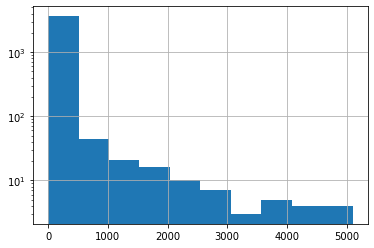

In [46]:
pd.Series(counts).hist(log=True);

In [47]:
pd.Series(counts).shape[0]

3745

In [48]:
(pd.Series(counts) > 1).sum()

1068

In [49]:
valid_words = [word for word, c in counts.items() if c > 1]
len(valid_words)

1068

In [50]:
def row_to_bools(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words])
bools = df.apply(row_to_bools, axis=1)
bools

,0,1,2,3,4,5,6,7,8,9,...,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,True,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,True,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,True,False,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
5977,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
5978,True,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,True
5979,True,False,False,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,True


In [85]:
cross_val_score(LinearRegression(), bools, df['Salario mensual BRUTO (en tu moneda local)']).mean()

-2.2969694106429625e+23

In [56]:
cross_val_score(LinearRegression(), bools, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

-7.868709709974668e+22

In [57]:
cross_val_score(xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}), bools, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.5888471948660807

In [50]:
encoding_dim = 10
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/500
18/18 [==============================] - 1s 30ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 2/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 3/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 4/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 5/500
18/18 [==============================] - 0s 17ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 6/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 7/500
18/18 [==============================] - 0s 17ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 8/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 9/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 10/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6935 - val_loss: 0.6935

18/18 [==============================] - 0s 18ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 163/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 164/500
18/18 [==============================] - 0s 19ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 165/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 166/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 167/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 168/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 169/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 170/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 171/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0

18/18 [==============================] - 0s 12ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 323/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 324/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 325/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 326/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 327/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 328/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 329/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 330/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 331/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0

18/18 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 483/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 484/500
18/18 [==============================] - 0s 14ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 485/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 486/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 487/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 488/500
18/18 [==============================] - 0s 12ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 489/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 490/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6913 - val_loss: 0.6913
Epoch 491/500
18/18 [==============================] - 0s 11ms/step - loss: 0.6913 - val_loss: 0

In [51]:
pd.DataFrame(encoded_imgs)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000000,0.000000,0.098485,0.239963,0.000000,0.093279,0.018019,0.000000,0.000000
1,0.0,0.027023,0.000000,0.257426,0.000000,0.000000,0.000000,0.000000,0.000000,0.100076
2,0.0,0.233498,0.000000,0.000000,0.000000,0.000000,0.153506,0.000000,0.248250,0.095124
3,0.0,0.527203,0.000000,0.542359,0.000000,0.238826,0.228102,0.000000,0.000000,0.018457
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006576,0.083529,0.000000
...,...,...,...,...,...,...,...,...,...,...
1124,0.0,0.030712,0.000000,0.128298,0.000000,0.082475,0.019732,0.000000,0.120398,0.226501
1125,0.0,0.369211,0.000000,0.000000,0.351084,0.217871,0.000000,0.000000,0.000000,0.000000
1126,0.0,0.462493,0.136517,0.178204,0.052546,0.093990,0.165075,0.000000,0.070231,0.000000
1127,0.0,0.160598,0.120532,0.281817,0.000000,0.000000,0.230088,0.066023,0.000000,0.000000


In [52]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067
5604,False,False,False,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2972,True,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2764,True,False,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1131,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
105,True,False,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,True,False,True,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2534,True,False,True,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4951,False,False,True,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2815,True,False,True,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
LinearRegression().fit(encoder.predict(X_train), y_train).score(encoded_imgs, y_test)

0.046996634616610855

In [54]:
LinearRegression().fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.05151873251866024

In [55]:
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.019529479693445873

In [56]:
encoding_dim = 100
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/500
18/18 [==============================] - 0s 19ms/step - loss: 0.6937 - val_loss: 0.6937
Epoch 2/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 3/500
18/18 [==============================] - 0s 17ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 4/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 5/500
18/18 [==============================] - 0s 17ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 6/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6937 - val_loss: 0.6936
Epoch 7/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 8/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 9/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 10/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6936 - val_loss: 0.6935

18/18 [==============================] - 0s 13ms/step - loss: 0.6912 - val_loss: 0.6912
Epoch 163/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6912 - val_loss: 0.6912
Epoch 164/500
18/18 [==============================] - 0s 20ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 165/500
18/18 [==============================] - 0s 20ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 166/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 167/500
18/18 [==============================] - 0s 21ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 168/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6912 - val_loss: 0.6911
Epoch 169/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 170/500
18/18 [==============================] - 0s 20ms/step - loss: 0.6911 - val_loss: 0.6911
Epoch 171/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6911 - val_loss: 0

18/18 [==============================] - 0s 14ms/step - loss: 0.6887 - val_loss: 0.6886
Epoch 323/500
18/18 [==============================] - 0s 14ms/step - loss: 0.6887 - val_loss: 0.6886
Epoch 324/500
18/18 [==============================] - 0s 18ms/step - loss: 0.6886 - val_loss: 0.6886
Epoch 325/500
18/18 [==============================] - 0s 19ms/step - loss: 0.6886 - val_loss: 0.6886
Epoch 326/500
18/18 [==============================] - 0s 22ms/step - loss: 0.6886 - val_loss: 0.6885
Epoch 327/500
18/18 [==============================] - 0s 19ms/step - loss: 0.6886 - val_loss: 0.6885
Epoch 328/500
18/18 [==============================] - 0s 20ms/step - loss: 0.6886 - val_loss: 0.6885
Epoch 329/500
18/18 [==============================] - 0s 17ms/step - loss: 0.6886 - val_loss: 0.6885
Epoch 330/500
18/18 [==============================] - 0s 23ms/step - loss: 0.6885 - val_loss: 0.6885
Epoch 331/500
18/18 [==============================] - 0s 21ms/step - loss: 0.6885 - val_loss: 0

18/18 [==============================] - 0s 14ms/step - loss: 0.6858 - val_loss: 0.6858
Epoch 483/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6858 - val_loss: 0.6858
Epoch 484/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6858 - val_loss: 0.6857
Epoch 485/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6858 - val_loss: 0.6857
Epoch 486/500
18/18 [==============================] - 0s 16ms/step - loss: 0.6858 - val_loss: 0.6857
Epoch 487/500
18/18 [==============================] - 0s 15ms/step - loss: 0.6857 - val_loss: 0.6857
Epoch 488/500
18/18 [==============================] - 0s 13ms/step - loss: 0.6857 - val_loss: 0.6857
Epoch 489/500
18/18 [==============================] - 0s 14ms/step - loss: 0.6857 - val_loss: 0.6856
Epoch 490/500
18/18 [==============================] - 0s 14ms/step - loss: 0.6857 - val_loss: 0.6856
Epoch 491/500
18/18 [==============================] - 0s 14ms/step - loss: 0.6857 - val_loss: 0

In [57]:
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoded_imgs, np.log(y_test))

0.4167061066474037

In [58]:
encoding_dim = 100
input_img = Input(shape=(bools.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))

Epoch 1/20
18/18 [==============================] - 0s 15ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 3/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/20
18/18 [==============================] - 0s 14ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/20
18/18 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/20
18/18 [==============================] - 0s 16ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/

0.3583131526464932

In [64]:
res = {};
for encoding_dim in range(1, 300):
    input_img = Input(shape=(bools.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


    X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
    autoencoder.fit(X_train, X_train,
                    epochs=4,
                    batch_size=256,
                    shuffle=True,
                    verbose=False)
    res[encoding_dim] = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
    ).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))
    if encoding_dim % 3 == 0:
        best = max(res.values())
        k = [k for k, v in res.items() if v == best]
        print(f'after {encoding_dim} best {k} ({best})')

after 3 best [1] (0.0030605559167709018)
after 6 best [1] (0.0030605559167709018)
after 9 best [9] (0.032150742899844875)
after 12 best [11] (0.10694081683470757)
after 15 best [14] (0.11967244551776557)
after 18 best [18] (0.13306281915442886)
after 21 best [21] (0.18068326857541062)
after 24 best [21] (0.18068326857541062)
after 27 best [25] (0.19883183779200908)
after 30 best [28] (0.24651105607771695)
after 33 best [33] (0.24973295381091165)
after 36 best [33] (0.24973295381091165)
after 39 best [39] (0.26400251873233727)
after 42 best [40] (0.3171089844217896)
after 45 best [40] (0.3171089844217896)
after 48 best [40] (0.3171089844217896)
after 51 best [50] (0.3345192696077304)
after 54 best [50] (0.3345192696077304)
after 57 best [50] (0.3345192696077304)
after 60 best [50] (0.3345192696077304)
after 63 best [61] (0.3658809778174903)
after 66 best [61] (0.3658809778174903)
after 69 best [67] (0.3897460512075588)
after 72 best [67] (0.3897460512075588)
after 75 best [67] (0.389746

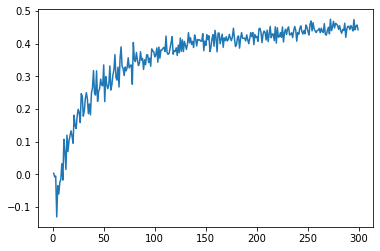

In [65]:
pd.Series(res).plot();

In [66]:
res = {};
for encoding_dim in range(300, 1000):
    input_img = Input(shape=(bools.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(bools.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


    X_train, X_test, y_train, y_test = train_test_split(bools, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
    autoencoder.fit(X_train, X_train,
                    epochs=4,
                    batch_size=256,
                    shuffle=True,
                    verbose=False)
    res[encoding_dim] = xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
    ).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))
    if encoding_dim % 3 == 0:
        best = max(res.values())
        k = [k for k, v in res.items() if v == best]
        print(f'after {encoding_dim} best {k} ({best})')

after 300 best [300] (0.4624377168122237)
after 303 best [300] (0.4624377168122237)
after 306 best [306] (0.47084735916643383)
after 309 best [306] (0.47084735916643383)
after 312 best [311] (0.4713344865644684)
after 315 best [311] (0.4713344865644684)
after 318 best [311] (0.4713344865644684)
after 321 best [311] (0.4713344865644684)
after 324 best [323] (0.4830163312794351)
after 327 best [323] (0.4830163312794351)
after 330 best [323] (0.4830163312794351)
after 333 best [323] (0.4830163312794351)
after 336 best [323] (0.4830163312794351)
after 339 best [323] (0.4830163312794351)
after 342 best [323] (0.4830163312794351)
after 345 best [323] (0.4830163312794351)
after 348 best [323] (0.4830163312794351)
after 351 best [350] (0.4849824100242087)
after 354 best [350] (0.4849824100242087)
after 357 best [350] (0.4849824100242087)
after 360 best [350] (0.4849824100242087)
after 363 best [350] (0.4849824100242087)
after 366 best [365] (0.49101769981087384)
after 369 best [365] (0.4910176

after 885 best [830] (0.5159707271485308)
after 888 best [830] (0.5159707271485308)
after 891 best [830] (0.5159707271485308)
after 894 best [830] (0.5159707271485308)
after 897 best [830] (0.5159707271485308)
after 900 best [830] (0.5159707271485308)
after 903 best [830] (0.5159707271485308)
after 906 best [830] (0.5159707271485308)
after 909 best [830] (0.5159707271485308)
after 912 best [830] (0.5159707271485308)
after 915 best [830] (0.5159707271485308)
after 918 best [830] (0.5159707271485308)
after 921 best [830] (0.5159707271485308)
after 924 best [830] (0.5159707271485308)
after 927 best [830] (0.5159707271485308)
after 930 best [830] (0.5159707271485308)
after 933 best [830] (0.5159707271485308)
after 936 best [830] (0.5159707271485308)
after 939 best [830] (0.5159707271485308)
after 942 best [830] (0.5159707271485308)
after 945 best [830] (0.5159707271485308)
after 948 best [830] (0.5159707271485308)
after 951 best [830] (0.5159707271485308)
after 954 best [830] (0.5159707271

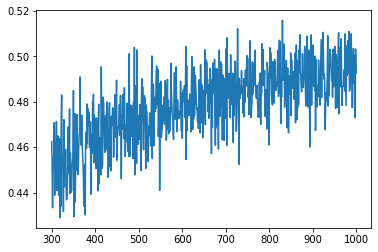

In [67]:
pd.Series(res).plot();

In [16]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Dónde estás trabajando',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1
len(counts)

3795

In [17]:
valid_words = [word for word, c in counts.items() if c > 1]
len(valid_words)

1072

In [18]:
def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [row['¿Gente a cargo?'], row['Años de experiencia']])
df_encoded = df.apply(encode_row, axis=1).astype(float)
df_encoded

,0,1,2,3,4,5,6,7,8,9,...,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,10.0
3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9.0
5977,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0
5978,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0
5979,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0


In [20]:
cross_val_score(xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6242316226258188

In [94]:
res = {};
encoding_dim = 830
input_img = Input(shape=(df_encoded.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(df_encoded.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


X_train, X_test, y_train, y_test = train_test_split(df_encoded, df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                verbose=False)
xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}
).fit(encoder.predict(X_train), np.log(y_train)).score(encoder.predict(X_test), np.log(y_test))

0.5486503219740979

In [19]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia']
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
df_encoded

,0,1,2,3,4,5,6,7,8,9,...,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,15.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,10.0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
4,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0
5977,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
5978,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
5979,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [61]:
cross_val_score(xgb.XGBRegressor(**{'gamma': 0.55, 'n_estimators': 230, 'colsample_bytree': 0.55, 'max_depth': 23, 'min_child_weight': 16.0, 'subsample': 0.7460131711512644, 'learning_rate': 0.05}), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.613505117044108

In [80]:
trials = Trials()

In [94]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(10, 30, dtype=int)),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 20, 1),
    'subsample': hp.uniform ('subsample', 0.8, 1),
    'n_estimators' : hp.choice('n_estimators', np.arange(10, 400, 5, dtype=int)),
    'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
}

X_train, X_test, y_train, y_test = train_test_split(df_encoded, pd.Series(np.log(df['Salario mensual BRUTO (en tu moneda local)'])), test_size=0.2, random_state=42)

def objective(space):
    classifier = xgb.XGBRegressor(**space)
    acc = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5).mean()
    print(space, acc)
    return {'loss': -acc, 'status': STATUS_OK}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

{'colsample_bytree': 0.8500000000000001, 'gamma': 0.8, 'learning_rate': 0.125, 'max_depth': 22, 'min_child_weight': 8.0, 'n_estimators': 15, 'subsample': 0.9873440787325349}
-5.630166565220671                                             
{'colsample_bytree': 0.7000000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.325, 'max_depth': 28, 'min_child_weight': 3.0, 'n_estimators': 355, 'subsample': 0.8703804515830457}
0.5834805452131973                                                                
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.125, 'max_depth': 29, 'min_child_weight': 2.0, 'n_estimators': 255, 'subsample': 0.8746830856390662}
0.6185126111088245                                                                
{'colsample_bytree': 0.65, 'gamma': 0.9500000000000001, 'learning_rate': 0.35000000000000003, 'max_depth': 24, 'min_child_weight': 2.0, 'n_estimators': 110, 'subsample': 0.9588136317417751}
0.5937399181242842                                      

0.5640686080355961                                                                 
{'colsample_bytree': 0.75, 'gamma': 0.8, 'learning_rate': 0.07500000000000001, 'max_depth': 24, 'min_child_weight': 17.0, 'n_estimators': 60, 'subsample': 0.8650267389756969}
0.5711227622725727                                                                 
{'colsample_bytree': 0.8, 'gamma': 0.9, 'learning_rate': 0.125, 'max_depth': 20, 'min_child_weight': 19.0, 'n_estimators': 375, 'subsample': 0.8119440420233659}
0.6220852286085391                                                                 
{'colsample_bytree': 0.9, 'gamma': 0.9500000000000001, 'learning_rate': 0.15000000000000002, 'max_depth': 28, 'min_child_weight': 12.0, 'n_estimators': 90, 'subsample': 0.8763086507988915}
0.6186227793680714                                                                 
{'colsample_bytree': 0.9500000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.275, 'max_depth': 29, 'min_child_weight': 4.0, 'n_

0.6181769941666022                                                                 
{'colsample_bytree': 0.8500000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.4, 'max_depth': 22, 'min_child_weight': 5.0, 'n_estimators': 255, 'subsample': 0.8253164544167355}
0.5720663760212314                                                                 
100%|██████████| 100/100 [53:24<00:00, 32.05s/trial, best loss: -0.6324749169400585]


In [95]:
best

{'colsample_bytree': 0.7000000000000001,
 'gamma': 0.65,
 'learning_rate': 0.05,
 'max_depth': 13,
 'min_child_weight': 8.0,
 'n_estimators': 47,
 'subsample': 0.8718795402022754}

In [19]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.65, 'learning_rate': 0.05, 'max_depth': 23, 'min_child_weight': 8.0, 'n_estimators': 245, 'subsample': 0.8718795402022754}

In [100]:
cross_val_score(xgb.XGBRegressor(**best), X_train, y_train).mean()

0.6324749169400585

In [101]:
xgb.XGBRegressor(**best).fit(X_train, y_train).score(X_test, y_test)

0.617811961352325

## Redes neuronales

In [118]:
model = Sequential(
    [
        Input(shape=(df_encoded.shape[1],)),
        Dense(1000, activation="relu", name="layer1"),
        Dense(1, name="output"),
    ]
)
model(X_train, y_train);
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
);
r2_score(y_test, model.predict(X_test))

Epoch 1/20
71/71 [==============================] - 0s 3ms/step - loss: 13.3906
Epoch 2/20
71/71 [==============================] - 0s 3ms/step - loss: 0.4979
Epoch 3/20
71/71 [==============================] - 0s 3ms/step - loss: 0.3545
Epoch 4/20
71/71 [==============================] - 0s 3ms/step - loss: 0.2263
Epoch 5/20
71/71 [==============================] - 0s 3ms/step - loss: 0.1894
Epoch 6/20
71/71 [==============================] - 0s 3ms/step - loss: 0.1288
Epoch 7/20
71/71 [==============================] - 0s 3ms/step - loss: 0.1166
Epoch 8/20
71/71 [==============================] - 0s 3ms/step - loss: 0.3779
Epoch 9/20
71/71 [==============================] - 0s 3ms/step - loss: 1.8324
Epoch 10/20
71/71 [==============================] - 0s 3ms/step - loss: 2.2506
Epoch 11/20
71/71 [==============================] - 0s 3ms/step - loss: 1.1104
Epoch 12/20
71/71 [==============================] - 0s 3ms/step - loss: 0.2455
Epoch 13/20
71/71 [=============================

0.45821176721657475

In [119]:
model = Sequential(
    [
        Input(shape=(df_encoded.shape[1],)),
        Dense(1000, activation="relu", kernel_regularizer=l1(0.01),
              activity_regularizer=l2(0.01)),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
);
r2_score(y_test, model.predict(X_test))

Epoch 1/20
71/71 [==============================] - 0s 4ms/step - loss: 117.3614
Epoch 2/20
71/71 [==============================] - 0s 4ms/step - loss: 14.9934
Epoch 3/20
71/71 [==============================] - 0s 4ms/step - loss: 8.2890
Epoch 4/20
71/71 [==============================] - 0s 4ms/step - loss: 6.8211
Epoch 5/20
71/71 [==============================] - 0s 4ms/step - loss: 9.3172
Epoch 6/20
71/71 [==============================] - 0s 4ms/step - loss: 5.1149
Epoch 7/20
71/71 [==============================] - 0s 4ms/step - loss: 4.9704
Epoch 8/20
71/71 [==============================] - 0s 4ms/step - loss: 4.8016
Epoch 9/20
71/71 [==============================] - 0s 4ms/step - loss: 3.2553
Epoch 10/20
71/71 [==============================] - 0s 4ms/step - loss: 3.1401
Epoch 11/20
71/71 [==============================] - 0s 4ms/step - loss: 3.5837
Epoch 12/20
71/71 [==============================] - 0s 4ms/step - loss: 3.3235
Epoch 13/20
71/71 [===========================

0.4333319475200501

In [120]:
model = Sequential(
    [
        Input(shape=(df_encoded.shape[1],)),
        Dense(1000, activation="relu", name="layer1"),
        Dense(1000, activation="relu", name="layer2"),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
);
r2_score(y_test, model.predict(X_test))

Epoch 1/20
71/71 [==============================] - 0s 5ms/step - loss: 8.5968
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4845
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.4242
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2707
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2879
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1525
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1541
Epoch 8/20
71/71 [==============================] - 0s 5ms/step - loss: 0.3732
Epoch 9/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2021
Epoch 10/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1382
Epoch 11/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1027
Epoch 12/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1049
Epoch 13/20
71/71 [==============================

0.42121911841233484

In [132]:
model = Sequential()
model.add(Input(shape=(df_encoded.shape[1],)))
model.add(Dense(1000, activation="relu", name="layer1"))
model.add(Dropout(0.1))
model.add(Dense(1000, activation="relu", name="layer2"))
model.add(Dropout(0.1))
model.add(Dense(1, name="output"))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=300,
    validation_data=(X_test, y_test)
);
r2_score(y_test, model.predict(X_test))

Epoch 1/300
71/71 [==============================] - 1s 7ms/step - loss: 52.1006 - val_loss: 0.5740
Epoch 2/300
71/71 [==============================] - 0s 6ms/step - loss: 0.7288 - val_loss: 0.3484
Epoch 3/300
71/71 [==============================] - 0s 6ms/step - loss: 0.6763 - val_loss: 0.4148
Epoch 4/300
71/71 [==============================] - 0s 6ms/step - loss: 0.4834 - val_loss: 0.2325
Epoch 5/300
71/71 [==============================] - 0s 7ms/step - loss: 0.4109 - val_loss: 0.2110
Epoch 6/300
71/71 [==============================] - 1s 8ms/step - loss: 0.3531 - val_loss: 0.2639
Epoch 7/300
71/71 [==============================] - 0s 7ms/step - loss: 0.3433 - val_loss: 0.2266
Epoch 8/300
71/71 [==============================] - 0s 6ms/step - loss: 0.3153 - val_loss: 0.6426
Epoch 9/300
71/71 [==============================] - 0s 7ms/step - loss: 0.7871 - val_loss: 0.4072
Epoch 10/300
71/71 [==============================] - 0s 6ms/step - loss: 0.5119 - val_loss: 0.3804
Epoch 11

71/71 [==============================] - 0s 6ms/step - loss: 0.1401 - val_loss: 0.2316
Epoch 84/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1191 - val_loss: 0.2318
Epoch 85/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1582 - val_loss: 0.2163
Epoch 86/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1633 - val_loss: 0.2094
Epoch 87/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1488 - val_loss: 0.2457
Epoch 88/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1279 - val_loss: 0.1927
Epoch 89/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1969 - val_loss: 0.2242
Epoch 90/300
71/71 [==============================] - 0s 6ms/step - loss: 0.2306 - val_loss: 0.2584
Epoch 91/300
71/71 [==============================] - 0s 6ms/step - loss: 0.2836 - val_loss: 0.2391
Epoch 92/300
71/71 [==============================] - 0s 6ms/step - loss: 0.2517 - val_loss: 0.4802
Epoch 93/300


71/71 [==============================] - 0s 6ms/step - loss: 0.0912 - val_loss: 0.1971
Epoch 246/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1165 - val_loss: 0.1963
Epoch 247/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1349 - val_loss: 0.2206
Epoch 248/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1132 - val_loss: 0.2258
Epoch 249/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1074 - val_loss: 0.1831
Epoch 250/300
71/71 [==============================] - 0s 6ms/step - loss: 0.1118 - val_loss: 0.1930
Epoch 251/300
71/71 [==============================] - 0s 7ms/step - loss: 0.0979 - val_loss: 0.1805
Epoch 252/300
71/71 [==============================] - 0s 7ms/step - loss: 0.1239 - val_loss: 0.1793
Epoch 253/300
71/71 [==============================] - 0s 6ms/step - loss: 0.0992 - val_loss: 0.2029
Epoch 254/300
71/71 [==============================] - 0s 7ms/step - loss: 0.0989 - val_loss: 0.2349
Epoc

0.462368917072295

In [22]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia'],
        row['Tengo'],
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
cross_val_score(xgb.XGBRegressor(**best), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6142830465101689

In [23]:
study_map = {
    'Primario': 0,
    'Secundario': 1,
    'Terciario': 2,
    'Universitario': 3,
    'Posgrado': 4,
    'Doctorado': 5,
    'Posdoctorado': 6,
}

def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Estado',
            'Carrera',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia'],
        row['Tengo'],
        study_map[row['Nivel de estudios alcanzado']],
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
cross_val_score(xgb.XGBRegressor(**best), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.61231987282598

In [24]:
def row_to_words(row):
    return [
        f'{key}={row[key]}'
        for key
        in (
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Estado',
            'Carrera',
            'Tengo',
            'Realizaste cursos de especialización',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            '¿Tenés guardias?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        )
    ] + [
        f'{k}={v.lower().strip().replace(".", "")}' for k in (
            '¿A qué eventos de tecnología asististe en el último año?',
            'Beneficios extra',
            'Plataformas',
            'Lenguajes de programación',
            'Frameworks, herramientas y librerías',
            'Bases de datos',
            'QA / Testing',
            'IDEs',
            'Lenguajes de programación'
        ) for v in row.fillna('')[k].split(', ')
    ] + [
        f'provincia={regions_map[row["Dónde estás trabajando"]]}'
    ]

counts = {}
for i in range(df.shape[0]):
    for word in row_to_words(df.iloc[i]):
        counts[word] = counts.get(word, 0) + 1

valid_words = [word for word, c in counts.items() if c > 1]


def encode_row(row):
    ws = row_to_words(row)
    return pd.Series([w in ws for w in valid_words] + [
        row['¿Gente a cargo?'],
        row['Años de experiencia']
    ])
df_encoded = df.apply(encode_row, axis=1).astype(float)
cross_val_score(xgb.XGBRegressor(**best), df_encoded, np.log(df['Salario mensual BRUTO (en tu moneda local)'])).mean()

0.6112829855406904